In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
import numpy as np

In [2]:
# read reservoir location dataset
res_location_fn = "../data/Reservoir-Locations.csv"
res_location = pd.read_csv(res_location_fn)

res_location.head()

,X,Y,YEAR,COUNTRY,RAT_ID,NAME,FNAME
0,100.450760,24.624938,1995.0,China,4,Manwan,5117
1,102.567564,18.539895,1972.0,Laos,5,Nam Ngum,Nam_Ngum_1
2,102.942516,18.442170,2000.0,Laos,6,Nam Leuk,5148
3,103.702018,17.259740,1973.0,Thailand,7,Nam Oun,5143
4,104.187228,17.194252,-99.0,Thailand,8,Nong Han Lake,5147


In [3]:
# meta variable, to save or not to save, that is the question
SAVE_FIG = True

# select one reservoir of choice to make initial plots
# resname = "Lam Pao"
# resname = "Sirindhorn"
# resname = "Ubol Ratana"
resname = "Nakai"
resinfo = res_location[res_location['NAME'] == resname]
resinfo

,X,Y,YEAR,COUNTRY,RAT_ID,NAME,FNAME
17,104.961191,17.93497,2010.0,Laos,21,Nakai,Nam_Theun_2


In [4]:
# Load TMS-OS dataset
tmsos_fn = f"../data/surface-areas/tmsos/{resinfo['FNAME'].values[0]}.csv"
tmsos_df = pd.read_csv(tmsos_fn, parse_dates=['date']).set_index('date')
tmsos_df.head(10)

,water_area_uncorrected,non_water_area,cloud_area,unfiltered_area,cloud_percent,QUALITY_DESCRIPTION,sat,filtered_area,corrected_areas_1,corrected_trend_1,sar_trend,days_passed,area
date,,,,,,,,,,,,,
2019-02-23,260.548323,399.173354,89.060144,290.823149,11.894005,0.0,s2,290.823149,290.823149,-1.956955,-0.116694,5.0,290.823149
2019-02-28,247.500665,363.888080,137.390804,291.729086,18.348632,0.0,s2,291.729086,291.729086,0.181187,-0.145868,5.0,291.729086
2019-03-05,233.178037,384.789251,130.814910,286.633898,17.470355,0.0,s2,286.633898,286.633898,-1.019038,-0.899425,5.0,286.633898
2019-03-06,262.544508,483.783001,2.454688,262.582864,0.327824,0.0,l8,262.582864,284.604135,-2.029762,-2.029762,1.0,284.604135
2019-03-10,290.776100,451.670886,6.334455,NaN,0.845968,0.0,s2,NaN,NaN,NaN,-2.029762,4.0,276.485086
2019-03-15,27.613115,533.680155,187.384038,NaN,25.028679,0.0,s2,NaN,NaN,NaN,-2.029762,5.0,266.336274
2019-03-20,210.500812,340.643452,197.637933,NaN,26.394582,0.0,s2,NaN,NaN,NaN,-3.624651,5.0,248.213018
2019-03-22,106.802104,579.216919,62.599082,NaN,8.361951,0.0,l8,NaN,NaN,NaN,-3.624651,2.0,240.963715
2019-03-25,147.076458,595.803407,5.901576,NaN,0.788157,0.0,s2,NaN,NaN,NaN,-3.624651,3.0,230.089762


In [5]:
CLOUD_THRESHOLD = 90
DATE_RANGE = (None, '2022-10-01')
tmsos_df = tmsos_df[(tmsos_df['cloud_percent'] < 90)]
tmsos_df = tmsos_df.loc[DATE_RANGE[0]:DATE_RANGE[1]]
# tmsos_df = tmsos_df.dropna(subset=['unfiltered_area'])

# tmsos_df = tmsos_df[(tmsos_df['QUALITY_DESCRIPTION'] != 0)]
# tmsos_df
picked_points = tmsos_df[['unfiltered_area', 'area']]
picked_points = picked_points[picked_points['unfiltered_area'] == picked_points['area']]

all_areas = tmsos_df[['unfiltered_area']]
unpicked_points = tmsos_df[['unfiltered_area', 'area']]
unpicked_points = unpicked_points[unpicked_points['unfiltered_area'] != unpicked_points['area']]

cloud_percent = tmsos_df['cloud_percent']

In [6]:
# unpicked_points.dropna()

In [7]:
# read in sar data
sar_fn = f"../data/surface-areas/sar/{resinfo['FNAME'].values[0]}_12d_sar.csv"
sar_df = pd.read_csv(sar_fn, parse_dates=['time']).rename({'time': 'date'}, axis=1).set_index('date')
sar_df.head()

,sarea
date,
2019-01-02 11:13:27,272.664349
2019-01-14 11:13:27,260.269160
2019-01-26 11:13:27,256.253115
2019-02-07 11:13:27,230.720274
2019-02-19 11:13:27,210.418491


# 2: One subplot showing the raw vs. tmsos derived surface area

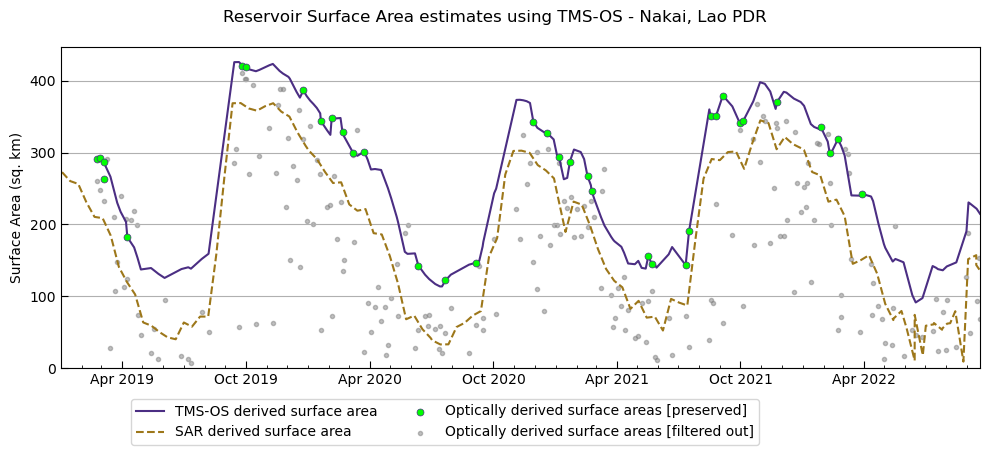

In [8]:
from matplotlib.dates import MonthLocator
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib import dates as md
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from scipy.interpolate import interp1d

f, ax = plt.subplots(
    figsize=(10, 4)
)
# f, (cloudax, ax) = plt.subplots(
#     figsize=(10, 5),
#     nrows = 2,
#     sharex=True, 
#     gridspec_kw={'height_ratios': [1, 5]}
# )

# colors for vertical lines
norm = mpl.colors.Normalize(vmin=0, vmax=100)
cmap = mpl.cm.get_cmap('RdYlGn_r')  # using available colormap

# creating own colormap
# nodes = [0.0, 0.05, 1.0]
# cmap = LinearSegmentedColormap.from_list("clouds", list(zip(nodes, ["lime", "white", "grey"])))
# colors = [cmap(norm(v)) for v in cloud_percent]
# alpha_mapper = interp1d([0, 100], [1, 0.3])
# alphas = [alpha_mapper(v) for v in cloud_percent]

norm = mpl.colors.Normalize(vmin=0, vmax=100)
cmap = mpl.cm.get_cmap('RdYlGn_r')
colors = [cmap(norm(v)) for v in cloud_percent]

# cloudax.vlines(cloud_percent.index, 0, cloud_percent.values, colors=colors)
# cloudax.grid(axis='y')
# cloudax.set_ylabel('Cloud (%)')

# cloudax.set_xlim(pd.to_datetime('2019-01-01'), tmsos_df.index.max())
# cloudax.set_ylim(0, 100)
# cloudax.set_yticks([50, 90])

final_hdl = tmsos_df['area'].plot(color='#4b2e83', label='TMS-OS derived surface area', ax=ax)
ax.plot(sar_df['sarea'], color='#9D771A', label='SAR derived surface area', linestyle='--', linewidth=1.5)
ax.scatter(all_areas.index, all_areas['unfiltered_area'], alpha=1, label='Optically derived surface areas [preserved]', marker='o', fc='lime', s=25, ec='#4b2e83', linewidth=0.5, zorder=10)
ax.scatter(tmsos_df.index, tmsos_df['water_area_uncorrected'], alpha=0.5, label='Optically derived surface areas [filtered out]', marker='.', color='grey')

# cax = f.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, pad=0.021, label='Cloud Cover (%)')
# cax.ax.invert_yaxis()

ax.grid(axis='y')

ax.tick_params(
    axis='x', 
    which='major',
    length=5
)
ax.tick_params(
    axis='x', 
    which='both', 
    direction = 'in'
)
ax.tick_params(
    axis='y', 
    which='major', 
    direction='in',
    length=5
)
ax.set_xlim(pd.to_datetime('2019-01-01'), tmsos_df.index.max())
ax.set_ylim(0, None)
ax.set_xlabel('')
ax.set_ylabel("Surface Area (sq. km)")

ax.set_xticklabels([], rotation='horizontal', ha='center')
ax.xaxis.set_major_locator(MonthLocator(bymonth=[4, 10]))
ax.xaxis.set_minor_locator(MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(md.DateFormatter('%b %Y'))

ax.yaxis.set_major_locator(ticker.MultipleLocator(100))

# cax.ax.tick_params(
#     axis='y',
#     length=2
# )

f.suptitle(f"Reservoir Surface Area estimates using TMS-OS - {resname}, Lao PDR")
f.legend(ncol=2, bbox_to_anchor=[0.45, 0.025], loc='upper center')
plt.tight_layout()

SAVE_FIG = True

if SAVE_FIG:
    savedir = "../results/2/"
    if not os.path.isdir(savedir):
        try:
            os.makedirs(savedir)
        except Exception as e:
            print(f"Could't create directory: {savedir}")
            raise e
    
    f.savefig(os.path.join(savedir, f"{resname}.png"), dpi=1600, bbox_inches='tight')

Modify the above figure for a non-scientific audience.

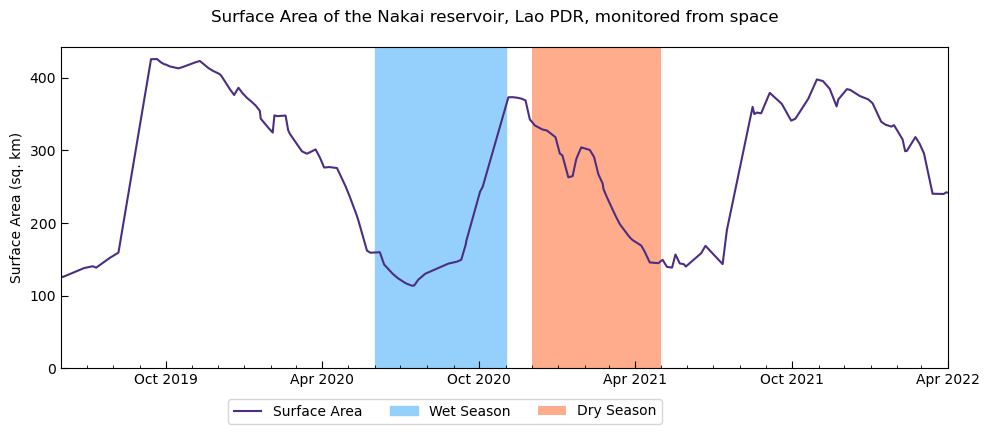

In [42]:
from matplotlib.dates import MonthLocator
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib import dates as md
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from scipy.interpolate import interp1d

f, ax = plt.subplots(
    figsize=(10, 4)
)

# colors for vertical lines
norm = mpl.colors.Normalize(vmin=0, vmax=100)
cmap = mpl.cm.get_cmap('RdYlGn_r')  # using available colormap

norm = mpl.colors.Normalize(vmin=0, vmax=100)
cmap = mpl.cm.get_cmap('RdYlGn_r')
colors = [cmap(norm(v)) for v in cloud_percent]

final_hdl = tmsos_df['area'].plot(color='#4b2e83', label='Surface Area', ax=ax)

# Show the wet season
ax.axvspan(pd.to_datetime("2020-06-01"), pd.to_datetime("2020-11-01"), color='xkcd:light blue', label='Wet Season')
ax.axvspan(pd.to_datetime("2020-12-01"), pd.to_datetime("2021-05-01"), facecolor='#FF763F', alpha=0.6, label='Dry Season')

# ax.grid(axis='none')

ax.tick_params(
    axis='x', 
    which='major',
    length=5
)
ax.tick_params(
    axis='x', 
    which='both', 
    direction = 'in'
)
ax.tick_params(
    axis='y', 
    which='major', 
    direction='in',
    length=5
)
ax.set_xlim(pd.to_datetime('2019-06-01'), pd.to_datetime('2022-04-01'))
ax.set_ylim(0, None)
ax.set_xlabel('')
ax.set_ylabel("Surface Area (sq. km)")

ax.set_xticklabels([], rotation='horizontal', ha='center')
ax.xaxis.set_major_locator(MonthLocator(bymonth=[4, 10]))
ax.xaxis.set_minor_locator(MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(md.DateFormatter('%b %Y'))

ax.yaxis.set_major_locator(ticker.MultipleLocator(100))

# cax.ax.tick_params(
#     axis='y',
#     length=2
# )

f.suptitle(f"Surface Area of the {resname} reservoir, Lao PDR, monitored from space")
f.legend(ncol=3, bbox_to_anchor=[0.45, 0.025], loc='upper center')
plt.tight_layout()

SAVE_FIG = True

if SAVE_FIG:
    savedir = "../results/2/"
    if not os.path.isdir(savedir):
        try:
            os.makedirs(savedir)
        except Exception as e:
            print(f"Could't create directory: {savedir}")
            raise e
    
    f.savefig(os.path.join(savedir, f"{resname}_non_scientific_audience.png"), dpi=300, bbox_inches='tight')